In [112]:
#Use cash-karp runge-kutta with adaptive stepwise control
#Evolve the system of equations dy/dx = z, dz/dx = -y
#Initial condintions y(x=0) = 0, dydx(x=0) = 1, evolve over range [0, 2pi]
#plot analytical solutions for y(x), dy/dx(x) over specified range and numerical olution
#plot absolute error for the numerical solutions of y(x) and dy/dx(x) over specified range

In [113]:
#Matplotlib and numpy
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [114]:
#Define functions
dfdx = lambda x, y: x**2 + x
f_int = lambda x, C: (x**3)/3. + 0.5*x**2 + C

In [115]:
#2nd order RK method
def rk2_core(x_i, f_i, h, g):
    #advance f by a step h
    
    #half step
    x_ipoh = x_i + 0.5 * h
    f_ipoh = f_i + 0.5 * h * g(x_i, f_i)
    
    f_ipo = f_i + h * g(x_ipoh, f_ipoh)
    
    return f_ipo

In [116]:
def rk2(dfdx, a, b, f_a, N):
    #dfdx derivative with respect to x
    #a is lower bound
    #b is upper bound
    #f_a is a boundary condition at a
    #N is the number of steps
    
    
    #define steps
    x = np.linspace(a, b, N)
    
    #a single step size
    h = x[1]-x[0]
    
    #array to hold f
    
    f = np.zeros(N, dtype=float)
    
    f[0] = f_a
    
    #evolve f along x
    for i in range(1, N):
        f[i] = rk2_core(x[i-1], f[i-1], h, dfdx)
        
    return x,f

In [117]:
def rk4_core(x_i, f_i, h, g):
    #define x as half step
    x_ipoh = x_i + 0.5 * h

    #define x at 1 step
    x_ipo = x_i + h

    k_1 = h * g(x_i, f_i)
    k_2 = h * g(x_ipoh, f_i + 0.5 * k_1)
    k_3 = h * g(x_ipoh, f_i + 0.5 * k_2)
    k_4 = h * g(x_ipo, f_i + k_3)

    f_ipo = f_i + (k_1 + 2 * k_2 + 2 * k_3 + k_4)/6.0

    return f_ipo

In [118]:
def rk4(dfdx, a, b, f_a, N):
    x = np.linspace(a, b, N)

    h = x[1] - x[0]

    f = np.zeros(N, dtype = float)
    f[0] = f_a

    for i in range(1, N):
        f[i] = rk4_core(x[i-1], f[i-1], h, dfdx)

    return x, f

In [119]:
#Evolve the system of equations dy/dx = z, dz/dx = -y
#Initial condintions y(x=0) = 0, dydx(x=0) = 1, evolve over range [0, 2pi]
#plot analytical solutions for y(x), dy/dx(x) over specified range and numerical olution
#plot absolute error for the numerical solutions of y(x) and dy/dx(x) over specified range

In [120]:
def dydx(x,y):
    y_derivs = np.zeros(2)
    y_derivs[0] = y[1]
    y_derivs[1] = -1 * y[0]
    return y_derivs

In [121]:
def rk4_mv_core(dydx, xi, yi, nv, h):
    k1 = np.zeros(nv)
    k2 = np.zeros(nv)
    k3 = np.zeros(nv)
    k4 = np.zeros(nv)
    x_ipoh = xi + 0.5 * h
    x_ipo = xi + h

    y_temp = np.zeros(nv)
    y_derivs = dydx(xi, yi)
    k1[:] = h * y_derivs[:]

    y_temp[:] = yi[:] + 0.5 * k1[:]
    y_derivs = dydx(x_ipoh, y_temp)
    k2[:] = h*y_derivs[:]

    y_temp[:] = yi[:] + 0.5 * k2[:]
    y_derivs = dydx(x_ipoh, y_temp)
    k3[:] = h*y_derivs[:]

    y_temp[:] = yi[:] + k3[:]
    y_derivs = dydx(x_ipoh, y_temp)
    k4[:] = h*y_derivs[:]

    yipo = yi + (k1 + 2 * k2 + 2 * k3 + k4)/6.

    return yipo



In [122]:
def rk4_mv_ad(dydx, x_i, y_i, nv, h, tol):
    SAFETY = 0.9
    H_NEW_FAC = 2.0
    imax = 10000
    i = 0
    Delta = np.full(nv, 2 * tol)
    h_step = h
    while(Delta.max()/tol > 1.0):
        y_2 = rk4_mv_core(dydx, x_i, y_i, nv, h_step)
        y_1 = rk4_mv_core(dydx, x_i, y_i, nv, 0.5 * h_step)
        y_11 = rk4_mv_core(dydx, x_i + 0.5 * h_step, y_1, nv, 0.5 * h_step)

        Delta = np.fabs(y_2 - y_11)

        if(Delta.max()/tol > 1.0):
            h_step *= SAFETY * (Delta.max()/tol)**(-0.25)

        if(i >= imax):
            print("too many iterations")
            raise StopIteration("Ending after ", i)

        i += 1
    
    h_new = np.fmin(h_step * (Delta.max()/tol) ** (-0.9), h_step * H_NEW_FAC)

    return y_2, h_new, h_step

In [123]:
def rk4_mv(dfdx, a, b, y_a, tol):
    xi = a
    yi = y_a.copy()
    h = 1.0e-4 * (b - a)
    imax = 10000
    i = 0
    nv = len(y_a)

    x = np.full(1, a)
    y = np.full((1, nv), y_a)

    flag = 1
    while(flag):
        yi_new, h_new, h_step = rk4_mv_ad(dydx, xi, yi, nv, h, tol)
        h = h_new
        
        if(xi + h_step > b):
            h = b-xi
            yi_new, h_new, h_step = rk4_mv_ad(dydx, xi, yi, nv, h, tol)

            flag = 0

        xi += h_step
        yi[:] = yi_new[:]

        x = np.append(x, xi)
        y_new = np.zeros((len(x), nv))
        y_new[0:len(x)-1,:] = y
        y_new[-1,:] = yi[:]
        del y
        y = y_new
        if(i >= imax):
            print("Maximum reached")
            raise StopIteration("Stopped after ", i)

        i += 1
        s = "i = %3d\tx = %9.8f\th = %9.8f\tb=%9.8f" % (i, xi, h_step, b)
        print(s)

        if(xi == b):
            flag = 0

    return x,y


i =   1	x = 0.00062832	h = 0.00062832	b=6.28318531
i =   2	x = 0.00188496	h = 0.00125664	b=6.28318531
i =   3	x = 0.00439823	h = 0.00251327	b=6.28318531
i =   4	x = 0.00942478	h = 0.00502655	b=6.28318531
i =   5	x = 0.01947787	h = 0.01005310	b=6.28318531
i =   6	x = 0.03958407	h = 0.02010619	b=6.28318531
i =   7	x = 0.07979645	h = 0.04021239	b=6.28318531
i =   8	x = 0.16022123	h = 0.08042477	b=6.28318531
i =   9	x = 0.32107077	h = 0.16084954	b=6.28318531
i =  10	x = 0.46816761	h = 0.14709684	b=6.28318531
i =  11	x = 0.60535502	h = 0.13718741	b=6.28318531
i =  12	x = 0.74522296	h = 0.13986794	b=6.28318531
i =  13	x = 0.88873209	h = 0.14350913	b=6.28318531
i =  14	x = 1.02700188	h = 0.13826979	b=6.28318531
i =  15	x = 1.16350434	h = 0.13650247	b=6.28318531
i =  16	x = 1.29828215	h = 0.13477781	b=6.28318531
i =  17	x = 1.43207856	h = 0.13379641	b=6.28318531
i =  18	x = 1.56536018	h = 0.13328163	b=6.28318531
i =  19	x = 1.69861470	h = 0.13325451	b=6.28318531
i =  20	x = 1.83231473	h = 0.13

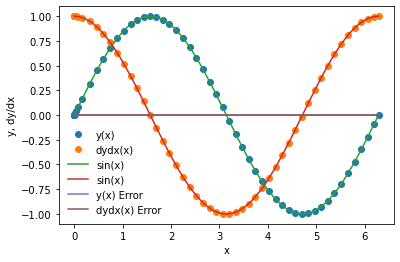

In [124]:
a = 0
b = 2.0 * np.pi
y_0 = np.zeros(2)
y_0[0] = 0.0
y_0[1] = 1.0
nv = 2

tolerance = 1.0e-6

x,y = rk4_mv(dydx, a, b, y_0, tolerance)
plt.plot(x, y[:,0], 'o', label = 'y(x)')
plt.plot(x, y[:,1], 'o', label = 'dydx(x)')
xx = np.linspace(0, 2.0 * np.pi, 1000)
plt.plot(xx, np.sin(xx), label = 'sin(x)')
plt.plot(xx, np.cos(xx), label = 'sin(x)')
plt.xlabel('x')
plt.ylabel('y, dy/dx')
plt.legend(frameon = False)

sine = np.sin(x)
cosine = np.cos(x)
y_error = (y[:,0]-sine)
dydx_error = (y[:,1] - cosine)

plt.plot(x, y_error, label = "y(x) Error")
plt.plot(x, dydx_error, label = "dydx(x) Error")
plt.legend(frameon = False)
